# Pretrained Model (ResNet34, CIFAR10)

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.2  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_dataset = datasets.CIFAR10(root = "/data_aug/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "/data_aug/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

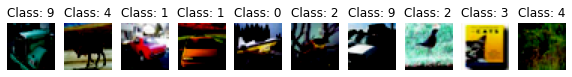

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

## Not pre-trained model (from scratch 학습?)

In [8]:
''' 6. PyTorch 내에서 제공하는 ResNet34 모델 불러온 후 FC 층 추가 및 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()

In [9]:
''' 7. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
''' 8. 불러온 Resnet34 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [11]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
if torch.cuda.is_available():
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               num_workers=12,
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                              persistent_workers=True)

In [13]:
%%time

''' 10. 불러온 ResNet34 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.919812
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.743259
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.566871
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.388460
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.574700
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.251327
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.061568
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.620300

[EPOCH: 1], 	Test Loss: 1.1899, 	Test Accuracy: 58.96 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.860132
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.303953
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.249170
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.122847
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.400946
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.455236
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.851767
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.082469

[EPOCH: 2], 	Test Loss: 1.0760, 	Test Accuracy: 62.54 % 

## pre-trained model (FC층만 학습?)

In [14]:
%%time

''' 11. IMAGENET 데이터로 학습이 된 ResNet34 모델을 불러온 후 Fine Tuning 해보기 '''
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.754993
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.236744
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.290043
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 0.885365
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.029635
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.951153
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.861316
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.133375

[EPOCH: 1], 	Test Loss: 0.9245, 	Test Accuracy: 67.59 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.922668
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.555641
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.678834
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.959351
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.779120
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.755628
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.694353
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.972591

[EPOCH: 2], 	Test Loss: 1.1278, 	Test Accuracy: 72.14 % 